This tutorial walks you through using the GizmoAnalysis package to read Gizmo simulation snapshots and analyzing them.

@author:
    Andrew Wetzel <arwetzel@gmail.com>
    Andrew Emerick <aemerick11@gmail.com>

First, move within a simulation directory, or set simulation_directory below to point to one. This directory should contain:
(1) a sub-directory 'output/' that contains Gizmo snapshot files: snapshot_*.hdf5 or snapdir_*/snapshot_*.*.hdf5
(2) a text file 'snapshot_times.txt' that lists the scale-factors, redshifts, times, and indices of all snapshots stored from the simulation
(3) optionally (but ideally) an 'initial_condition/' directory that contains a MUSIC configuration file named '*.conf' that stores all 6 cosmological parameters. if the simulation directory does not contain, this, GizmoAnalysis will assume the same cosmological parameters as in the AGORA simulation.

Ensure that the gizmo_analysis and utilities package directories are in your python path, then...

In [5]:
import gizmo_analysis as gizmo
import utilities as ut

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# you can access the files as named or use the aliases in __init__.py to keep it shorter 
# for example, these are the same:

gizmo.gizmo_io
gizmo.io

# read particle data

In [1]:
# we recommend that you copy this jupyter notebook tutorial into a simulation directory 
# (for example, m12i_res7100/) and run from there.
# however, you can set simulation_directory below to point to any simulation directory and then run this notebook from anywhere

# use this is you are running from within a simulation directory
#simulation_directory = '.'

# use this to point to a specific simulation directory, if you run this notebook from somwhere else
simulation_directory = '/Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000'

In [ ]:
# read star and dark-matter particles at z = 0

part = gizmo.io.Read.read_snapshots(['star', 'dark'], 'redshift', 0, simulation_directory)

In [ ]:
# alternately, read all particle species at z = 0

part = gizmo.io.Read.read_snapshots('all', 'redshift', 0, simulation_directory)

In [ ]:
# part is a dictionary with each particle species name as key
# 'star' = stars, 'gas' = gas, 'dark' = dark matter,
# 'dark2', 'dark3', 'dark4', etc = low-resolution dark matter (you rarely will be interested in it)

part.keys()

In [ ]:
# each species is its own dictionary that contains arrays of properties

part['star'].keys()

In [ ]:
# list the properties of dark-matter particles

part['dark'].keys()

In [ ]:
# list the properties of gas particles

part['gas'].keys()

# particle properties

In [ ]:
# 3-D position of each star particle, stored in a particle_number x dimension_number array [kpc comoving]

part['star']['position']

In [ ]:
# 3-D velocity of each star particle (particle_number x dimension_number array) [km / s]

part['star']['velocity']

In [ ]:
# mass of each star particle [M_sun]

part['star']['mass']

In [ ]:
# formation scale-factor of each star particle

part['star']['form.scalefactor']

In [ ]:
# IMPORTANT FEATURE
# use .prop() to compute derived quantities, such as the time [in Gyr] when each star particle formed
# see gizmo.io.ParticleDictionaryClass for all options for derived quantities

part['star'].prop('form.time')

In [ ]:
# similarly, get the age of each star particle (the lookback time to when it formed) [Gyr]

part['star'].prop('age')

In [ ]:
# get the mass of each star particle when it formed [Msun], using the stellar evolution tracks in Gizmo
# this initially sets up an internally stored spline to compute this

part['star'].prop('form.mass')

# elemental abundances (metallicities)

In [ ]:
# elemental abundances are stored in the particle catalog as linear mass fractions
# one value for each element, in a particle_number x element_number array
# the first value is the mass fraction of all metals (everything not H, He)
# then He, C, N, O, etc

part['star']['massfraction']

In [ ]:
# get individual elements by their array index

# total metal mass fraction (everything not H, He) is index 0
print(part['star']['massfraction'][:, 0])

# iron is index 10
print(part['star']['massfraction'][:, 10])

In [ ]:
# more conveniently, use .prop() to compute derived quantities, including calling element by its name or symbol
# see gizmo.io.ParticleDictionaryClass for all options for derived quantities

print(part['star'].prop('massfraction.metals'))
print(part['star'].prop('massfraction.carbon'))
print(part['star'].prop('massfraction.iron'))
print(part['star'].prop('massfraction.fe'))  # you can use name or symbol

In [ ]:
# also use .prop() to compute 'metallicity' [Z / H]
# for example, iron abundance [Fe / H] :=
#   log10((mass_iron / mass_hydrogen)_particle / (mass_iron / mass_hydrogen)_sun)
# GizmoAnalysis assumes solar abundances from Asplund et al 2009

print(part['star'].prop('metallicity.total'))
print(part['star'].prop('metallicity.fe'))

In [ ]:
# you also can use .prop() to compute simple arithmetic combinations, such as [Mg / Fe]

part['star'].prop('metallicity.mg - metallicity.fe')

In [ ]:
# refer to utilities.basic.constant for assumed solar values (Asplund et al 2009) and other constants

ut.constant.sun_composition

# meta-data about simulation

The dictionary that stores the particle catalog is actually a dictionary class. It also stores meta-data about the simulation and ancillary data/functions via appended dictionaries, classes, and arrays.

In [ ]:
# dictionary of useful information about the simulation

part.info

In [ ]:
# dictionary of information about the snapshot that you read
# its index (number), scale-factor, redshift, time, lookback-time

part.snapshot

In [ ]:
# dictionary class with information about *all* snapshots (typically ~600) saved for this simulation

print(part.Snapshot.keys())
print(part.Snapshot['redshift'][:10])

In [ ]:
# dictionary class of cosmological parameters, with internal functions for cosmological conversions
# see utilities.cosmology for more

part.Cosmology

See gizmo_plot.py (which you can access here via gizmo.plot) for examples of analyzing and plotting particle data.

See utilities/particle.py (which you can acces here via ut.particle) for mid-level analysis functions that may be useful.

See other modules within utilities for low-level functions that may be useful.

# coordinates of host galaxy/halo and principal axes of stellar disk

If you enable gizmo.io.Read.read_snapshots(assign_hosts=True) (which is True by default), then during read-in, GizmoAnalysis assigns the position and velocity of the host galaxy/halo (using stars for a baryonic simulations and dark matter for a dark-matter-only simulation). GizmoAnalysis stores these coordinates in arrays appended to the particle dictionary.

Most simulations have a single host galaxy/halo, but some (like ELVIS) contain 2 (or more). You can control the number of hosts via: read_snapshots(host_number=2) (by deafult, host_number=1).

Once the code assigns the coordinates of each host, it also can compute the 'orientation' of the disk, by computing the rotation tensor and axis ratios of the principal axes of each host's stellar disk, defined via the moment of inertia tensor of young star particles. Enable this via: read_snapshots(assign_hosts_rotation=True) (by default, assign_hosts_rotation=False).

If someone has run particle tracking on the simulation, including generating a file track/host_coordinates.hdf5, this stores the posiion, velocity, rotation tensor, and axis ratio of each host galaxy at each snapshot, so you do not have to re-compute during every read. If you set assign_hosts=True or assign_hosts_rotation=True in read_snapshots(), then GizmoAnalysis first will look for this file, and assign the host information stored in it, but if it does not find the file, GizmoAnalysis will assign these host properties on the fly during read.

In [ ]:
# position [kpc comoving] and velocity [km / s] of the center of each host galaxy
# can store multiple hosts, though usually just one

print(part.host['position'])
print(part.host['velocity'])

In [ ]:
# compute and assign the rotation tensor and axis ratios of the principal axes (defined via moment of inertia tensor) of stars in each host,  during read in as below

part = gizmo.io.Read.read_snapshots(['star', 'dark'], 'redshift', 0, simulation_directory, assign_hosts_rotation=True)

In [ ]:
# stores the rotation tensor, to rotate into the principal axes for each host

print(part.host['rotation'])

In [ ]:
# and stores the axis ratios (min/maj, min/med, med/maj) for each host

print(part.host['axis.ratios'])

In [ ]:
# now you can compute different types of distances of star particles from the center of each host galaxy
# using .prop() to call derived quantities
# compute 3-D distance from the host center along simulation's default x,y,z cartesian axes [kpc physical]

part['star'].prop('host.distance')

In [ ]:
# add '.total' to compute total (scalar) distance [kpc physical]

part['star'].prop('host.distance.total')

In [ ]:
# add '.principal' to compute 3-D distance aligned with the principal (major, intermediate, minor) axes of each host's stellar disk [kpc physical]

part['star'].prop('host.distance.principal')

In [ ]:
# add '.cylindrical' or '.cyl' to compute 3-D distance aligned with the principal axes in cylindrical coordinates
# first value is along the major axes (R, positive definite) [kpc physical]
# second value is angle (phi, 0 to 2 * pi) [radian]
# third value is vertical height wrt the disk (Z, signed) [kpc physical]

part['star'].prop('host.distance.principal.cylindrical')

In [ ]:
# same for velocity
# compute 3-D velocity from each host galaxy center along simulation's default x,y,z cartesian axes [km / s]

part['star'].prop('host.velocity')

In [ ]:
# compute total (scalar) velocity [km / s]

part['star'].prop('host.velocity.total')

In [ ]:
# compute 3-D velocity along the principal (major, intermediate, minor) axes [km / s]

part['star'].prop('host.velocity.principal')

In [ ]:
# compute 3-D velocity in cylindrical coordinates
# first value is along the major axes (positive definite)
# secod value is azimuthal velocity in the plane of the disk (positive definite)
# third value is vertical velocity wrt the disk (signed)

part['star'].prop('host.velocity.principal.cylindrical')

In [ ]:
# if you want to store multiple hosts (such as for the ELVIS Local Group-like paired host simulations), 
# set host_number=2 during read-in
# (in fact, you can do this for any simulation, it simply finds the second most massive host galaxy in the zoom-in region)

part = gizmo.io.Read.read_snapshots(['star', 'dark'], 'redshift', 0, simulation_directory, host_number=2, assign_hosts='mass', assign_hosts_rotation=True)

In [ ]:
# everything above still works, just use 'host', 'host2', 'host3', etc to identify which host you want coordinates relative to

print(part['star'].prop('host.distance'))
print(part['star'].prop('host2.distance'))

In [ ]:
# the particle dictionary stores coordinates and rotation tensors for each host

print(part.host['position'])
print(part.host['velocity'])
print(part.host['rotation'])
print(part.host['axis.ratios'])

# star + gas particle tracking

Some simulations have pre-compiled HDF5 files for tracking star + gas particles over time. By default, we store these files in the directory 'track/' (if present). gizmo_track.py contains the code that generates and reads these files.

star\_gas\_pointers\_\*.hdf5 files store, for each star and gas particles at z = 0, a pointer to its array index in the catalog at each previous snapshot (replace * with snapshot index). This makes it easy to get the properties of a given star particle at any previous snapshot. We store these pointers in an HDF5 file, one for each previous snapshot.

### tracking between z = 0 and a previous snapshot

In [2]:
# read catalog of star and gas particles at z = 0

part_at_z0 = gizmo.io.Read.read_snapshots(['star', 'gas'], 'redshift', 0, simulation_directory)


# in utilities.simulation.Snapshot():
* reading:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/output/snapshot_600.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 8820344 particles
    dark2     (id = 2): 3081337 particles
    gas       (id = 0): 5969934 particles
    star      (id = 4): 3059250 particles
    blackhole (id = 5): 0 particles

* reading species: ['star', 'gas']
* reading particles from:
    Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/output/snapshot_600.hdf5

* reading cosmological parameters from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/initial_condition/ic_agora_m12i.conf

* checking sanity of pa

In [3]:
# for example, you want to find out what they were doing at z = 2
# read in catalog of star particles at z = 2 (probably snapshot 172)
# set assign_pointers=True to assign such pointers to the particle catalog at z = 2

part_at_z2 = gizmo.io.Read.read_snapshots(
    ['star', 'gas'], 'redshift', 2, simulation_directory, assign_pointers=True)


# in utilities.simulation.Snapshot():
* reading:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/snapshot_times.txt

* input redshift = 2:  using snapshot index = 172, redshift = 2.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/output/snapshot_172.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 8820344 particles
    dark2     (id = 2): 3081337 particles
    gas       (id = 0): 8575137 particles
    star      (id = 4): 245223 particles
    blackhole (id = 5): 0 particles

* reading species: ['star', 'gas']
* reading particles from:
    Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/output/snapshot_172.hdf5

* reading cosmological parameters from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/initial_condition/ic_agora_m12i.conf

* checking sanity of par

In [4]:
# we store particle pointers via a dictionary class appended to particle catalog dictionary at the relevant snapshot
# a negative value means that the star formed after this snapshot (so it does not exist at this snapshot)

part_at_z2.Pointer

{'species': array(['star', 'gas'], dtype='<U4'),
 'z.gas.index.limits': array([ 245223, 8820360]),
 'z.gas.number': 8575137,
 'z.particle.number': 8820360,
 'z.snapshot.index': 172,
 'z.star.index.limits': array([     0, 245223]),
 'z.star.number': 245223,
 'z0.gas.index.limits': array([3059250, 9029184]),
 'z0.gas.number': 5969934,
 'z0.particle.number': 9029184,
 'z0.snapshot.index': 600,
 'z0.star.index.limits': array([      0, 3059250]),
 'z0.star.number': 3059250,
 'z0.to.z.index': array([8762407, 6627790, 2897974, ...,  428042, 1883434, 1569509],
       dtype=int32)}

In [5]:
# the particle species that we have compiled tracking pointers for

part_at_z2.Pointer['species']

array(['star', 'gas'], dtype='<U4')

In [6]:
# the snapshot indices at this redshift (z = 2) and at the reference redshift (z = 0)

print(part_at_z2.Pointer['z.snapshot.index'])
print(part_at_z2.Pointer['z0.snapshot.index'])

172
600


In [7]:
# the number of particles at this redshift (z = 2) and at the reference redshift (z = 0)

print(part_at_z2.Pointer['z.star.number'])
print(part_at_z2.Pointer['z.gas.number'])

print(part_at_z2.Pointer['z0.star.number'])
print(part_at_z2.Pointer['z0.gas.number'])

245223
8575137
3059250
5969934


In [8]:
# the dictionaries below store the actual pointer indices
# becase gas particles can become star particles, this pipeline concatenates the particle list and 
# stores pointers from this combined star + gas list at z = 0 to z

print(part_at_z2.Pointer['z0.to.z.index'])

# this also stores the limits of the indices of each species at each snapshot, 
# so you can convert back to the index within the individual star list or the individual gas list 
# (as stored in the particle catalog)
print(part_at_z2.Pointer['z.star.index.limits'])
print(part_at_z2.Pointer['z.gas.index.limits'])

print(part_at_z2.Pointer['z0.star.index.limits'])
print(part_at_z2.Pointer['z0.gas.index.limits'])

[8762407 6627790 2897974 ...  428042 1883434 1569509]
[     0 245223]
[ 245223 8820360]
[      0 3059250]
[3059250 9029184]


In [9]:
# more simply, you can use this function to get pointers for a given species from z = 0 to any z
# the default mode of tracking is going backward in time (from z = 0 to z)

pointers = part_at_z2.Pointer.get_pointers(species_name_from='star', species_names_to='star')

In [10]:
# say that you have a list of star particle indices of interest at z = 0

indices_at_z0 = np.array([5, 8, 13])

# list their positions at z = 0
part_at_z0['star']['position'][indices_at_z0]

array([[43395.66430266, 44225.91487342, 46848.42028784],
       [43391.32501013, 44235.3333939 , 46851.26898524],
       [43392.7246372 , 44234.88455716, 46860.08437896]])

In [11]:
# now you can get their indices in the particle catalog at z = 2
# negative indices means that the star particle did not exist at z = 2

indices_at_z2 = pointers[indices_at_z0]
print(indices_at_z2)

# now you easily can get any property of interest at z = 2, for example, positions
part_at_z2['star']['position'][indices_at_z2]

[93570 93569 93574]


array([[44594.70662236, 42857.76681624, 45680.41942321],
       [44597.17009857, 42856.9103464 , 45683.54318435],
       [44586.14301487, 42869.01990286, 45673.47361522]])

In [12]:
# alternatively, you can track particles going forward in time by setting forward=True

pointers = part_at_z2.Pointer.get_pointers(species_name_from='star', species_names_to='star', forward=True)

indices_at_z2 = np.array([5, 8, 13])
indices_at_z0 = pointers[indices_at_z2]
print(indices_at_z0)
print(part_at_z0['star']['position'][indices_at_z0])

[1081507 2621944 1378523]
[[41827.95243832 44124.6273934  46289.64224645]
 [41810.05286106 44110.48518841 46285.84784929]
 [41827.05895642 44116.02070015 46284.00376819]]


In [13]:
# also, you can track star particles back to both progenitor star and progenitor gas particles

pointers = part_at_z2.Pointer.get_pointers(species_name_from='star', species_names_to=['star', 'gas'])

# but now, pointers is a *dictionary* that stores both the index and species of each progenitor particle
print(pointers)

# get star particle indices at z = 0 and see what they were at z = 2
star_indices_at_z0 = np.array([0, 5, 8, 13])
print(pointers['species'][star_indices_at_z0], pointers['index'][star_indices_at_z0])

# get those that were gas particles
masks = np.where(pointers['species'][star_indices_at_z0] == 'gas')[0]

gas_indices_at_z2 = pointers['index'][star_indices_at_z0[masks]]

print(gas_indices_at_z2)
print(part_at_z2['gas']['position'][gas_indices_at_z2])

{'index': array([8517184, 6382567, 2652751, ..., 5870729,  297634,  179265],
      dtype=int32), 'species': array(['gas', 'gas', 'gas', ..., 'gas', 'gas', 'star'], dtype='<U4')}
['gas' 'star' 'star' 'star'] [8517184   93570   93569   93574]
[8517184]
[[42845.52824108 42506.12287672 44870.50121988]]


In [14]:
# similar for working forward in time, track gas particles at z that can be star or gas particles at z = 0

pointers = part_at_z2.Pointer.get_pointers(
    species_name_from='gas', species_names_to=['star', 'gas'], forward=True)

# get gas indices at z = 2 and see what they end up as at z = 0
gas_indices_at_z2 = np.array([0, 5, 8, 13])
print(pointers['species'][gas_indices_at_z2])
print(pointers['index'][gas_indices_at_z2])

# get those that are star particles at z = 0
masks = np.where(pointers['species'][gas_indices_at_z2] == 'star')[0]

star_indices_at_z0 = pointers['index'][gas_indices_at_z2[masks]]

print(star_indices_at_z0)
print(part_at_z0['star']['position'][star_indices_at_z0])

['star' 'star' 'gas' 'gas']
[ 215205 1917430 1826927 4148144]
[ 215205 1917430]
[[41823.76116895 44122.68646199 46287.49155757]
 [41813.98704585 44118.76742237 46303.17274406]]


### tracking between 2 snapshots in which both are at z > 0

In [15]:
# particle tracking also can handle tracking particles between any 2 snapshots

# read catalogs of star and gas particles at z = 1 and 2, including their pointers relative to z = 0
# set asign_pointers=True automatically to append pointer class to each particle catalog
part_at_z1 = gizmo.io.Read.read_snapshots(
    ['star', 'gas'], 'redshift', 1, simulation_directory, assign_pointers=True)
part_at_z2 = gizmo.io.Read.read_snapshots(
    ['star', 'gas'], 'redshift', 2, simulation_directory, assign_pointers=True)


# in utilities.simulation.Snapshot():
* reading:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/snapshot_times.txt

* input redshift = 1:  using snapshot index = 277, redshift = 1.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/output/snapshot_277.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 8820344 particles
    dark2     (id = 2): 3081337 particles
    gas       (id = 0): 7498674 particles
    star      (id = 4): 1333580 particles
    blackhole (id = 5): 0 particles

* reading species: ['star', 'gas']
* reading particles from:
    Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/output/snapshot_277.hdf5

* reading cosmological parameters from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/initial_condition/ic_agora_m12i.conf

* checking sanity of pa

In [16]:
# now just append intermediate-redshift pointers (to z = 1) to pointers at z = 2

part_at_z2.Pointer.add_intermediate_pointers(part_at_z1.Pointer)

In [17]:
# now you can access pointers from z = 1 to z = 2, by setting intermediate_snapshot=True

pointers = part_at_z2.Pointer.get_pointers(
    species_name_from='star', species_names_to=['star', 'gas'], intermediate_snapshot=True)

# get star indices at z = 0 and see what they were at z = 2
star_indices_at_z1 = np.array([0, 5, 8, 13])
print(pointers['species'][star_indices_at_z1])
print(pointers['index'][star_indices_at_z1])

# get those that are star particles at z = 2
masks = np.where(pointers['species'][star_indices_at_z1] == 'star')[0]

star_indices_at_z2 = pointers['index'][star_indices_at_z1[masks]]

print(star_indices_at_z2)
print(part_at_z2['star']['position'][star_indices_at_z2])

['star' 'gas' 'gas' 'gas']
[ 107166 1169600 6377478  239484]
[107166]
[[43535.53900573 42053.83122207 46265.70989359]]


In [18]:
# if you just want to track a single species (star -> star or gas -> gas) between 2 snapshots,
# read_pointers_between_snapshots() makes it easy to get the pointer indices between any 2 snapshots

ParticlePointer = gizmo.track.ParticlePointerClass(simulation_directory=simulation_directory)

# tracking forward in time
pointers_z2_to_z1 = ParticlePointer.read_pointers_between_snapshots(
    snapshot_index_from=172, snapshot_index_to=277, species_name='star')

# for example, see how far star particles have moved
print(part_at_z2['star']['position'] - part_at_z1['star']['position'][pointers_z2_to_z1])


# similar for tracking going backward in time
pointers_z1_to_z2 = ParticlePointer.read_pointers_between_snapshots(
    snapshot_index_from=277, snapshot_index_to=172, species_name='star')

# in this case, need to select stars that existed as stars at z = 2
masks = (pointers_z1_to_z2 >= 0)

# see how far star particles have moved
print(part_at_z1['star']['position'][masks] - part_at_z1['star']['position'][pointers_z1_to_z2[masks]])


# in gizmo_analysis.gizmo_track.ParticlePointer():
* read particle pointers from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/track/star_gas_pointers_277.hdf5
* read particle pointers from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/track/star_gas_pointers_172.hdf5
[[ 292.68991569 -383.58753865 -537.01238787]
 [ 340.40628092 -396.67310129 -443.35512543]
 [ 325.33277499 -341.7086024  -510.64487315]
 ...
 [ -99.12561147   30.8602316  -350.24431613]
 [ -99.82395539   11.77529703 -343.91413721]
 [ -94.33690426   50.91985599 -359.29941783]]
* read particle pointers from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/track/star_gas_pointers_172.hdf5
* read particle pointers from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/track/star_gas_pointers_277.hdf5
[[ 1.76618861e+03 -1.34864646e+03  3.38039285e+03]
 [-3.19344155e-01  1.92092919e+01 -1.4040

In [19]:
# do the same, but for gas

ParticlePointer = gizmo.track.ParticlePointerClass(simulation_directory=simulation_directory)

# tracking going forward in time
pointers_z2_to_z1 = ParticlePointer.read_pointers_between_snapshots(
    snapshot_index_from=172, snapshot_index_to=277, species_name='gas')

# ensure that gas particle still is a gas particle at z = 1
masks = (pointers_z2_to_z1 >= 0)

print(part_at_z2['gas']['position'][masks] - part_at_z1['gas']['position'][pointers_z2_to_z1[masks]])

# tracking going backward in time
pointers_z1_to_z2 = ParticlePointer.read_pointers_between_snapshots(
    snapshot_index_from=277, snapshot_index_to=172, species_name='gas')

# for gas, still have to ensure positive pointers, even if tracking going backward in time,
# because a few gas particles that leave the zoom-in region get culled (for numerical stability) by z = 0
# (remember that the pointers always route through z = 0)
masks = (pointers_z1_to_z2 >= 0)

print(part_at_z1['gas']['position'][masks] - part_at_z2['gas']['position'][pointers_z1_to_z2[masks]])


# in gizmo_analysis.gizmo_track.ParticlePointer():
* read particle pointers from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/track/star_gas_pointers_277.hdf5
* read particle pointers from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/track/star_gas_pointers_172.hdf5
[[ 224.35345256 -102.50255757 -208.25313603]
 [ 313.50763315 -345.17309798 -495.19974925]
 [ 114.49285425  233.74061457 -177.28187293]
 ...
 [  53.25622074 -595.53442327  -88.54922416]
 [  57.46695114 -592.76897158  -83.2795691 ]
 [  58.68275013 -596.29758723  -82.94903887]]
* read particle pointers from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/track/star_gas_pointers_172.hdf5
* read particle pointers from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/track/star_gas_pointers_277.hdf5
[[-560.31238357 -135.1138063   780.92769312]
 [-683.88542357 -173.21415443  796.86951148]
 [

# star particle formation coordinates

As part of star particle tracking, we store the position and velocity of each star particle immediately after it formed. Because we typically store snapshots every 20 - 25 Myr, this means that these 'formation' coordiantes are the coordinates of a star particle0 - ~25 Myr after it formed.

Within track/, host_coordinates.hdf5 stores, for each star particle at z = 0, its 3-D distance and 3-D velocity wrt to the main host galaxy at the first snapshot after it formed. These coordinates are aligned with the principal (major, intermediate, minor) axes of the stellar disk (as defined via its moment of inertia tensor) at that snapshot.

In [20]:
# use the function within gizmo_track.py to read this file and assign values directly to the catalog at z = 0

gizmo.track.ParticleCoordinate.io_hosts_and_formation_coordinates(part_at_z0, simulation_directory)


# in utilities.basic.io.file_hdf5():
  reading file:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/track/host_coordinates.hdf5
    host.axis.ratios | float32, shape = (601, 1, 3)
    host.position | float32, shape = (601, 1, 3)
    host.rotation | float32, shape = (601, 1, 3, 3)
    host.velocity | float32, shape = (601, 1, 3)
    snapshot.index | int64, shape = ()
    star.form.host.distance | float32, shape = (3059250, 3)
    star.form.host.velocity | float32, shape = (3059250, 3)
    star.id | uint32, shape = (3059250,)
  reading formation coordinates for star particles at snapshot 600


In [21]:
# more conveniently, you can read the formation coordinates of star particles during snapshot read-in
# by setting assign_formation_coordinates=True

part_at_z0 = gizmo.io.Read.read_snapshots(
    ['star'], 'redshift', 0, simulation_directory, assign_hosts_rotation=True, 
    assign_formation_coordinates=True)


# in utilities.simulation.Snapshot():
* reading:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/output/snapshot_600.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 8820344 particles
    dark2     (id = 2): 3081337 particles
    gas       (id = 0): 5969934 particles
    star      (id = 4): 3059250 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/output/snapshot_600.hdf5

* reading cosmological parameters from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/initial_condition/ic_agora_m12i.conf

* checking sanity of particle 

In [22]:
# 3-D distance at formation
# this is aligned with the principal axes of each host galaxy at that time [kpc physical]
# we compute the principal axes *independently* at each snapshot
# distance along dimension 0 is aligned with the major axiss
# distance along dimension 1 is algined with the intermediate axis
# distance along dimension 2 is aligned with the minor (Z) axis

part_at_z0['star']['form.host.distance']

# part_at_z0['star']['form.host2.distance']  # if the simulation has a second host galaxy (for example, ELVIS)

array([[ 4.5457406e+00,  5.7589731e+00, -1.0328604e+00],
       [ 8.9594122e+02, -1.1873512e+03,  5.4280817e+02],
       [ 1.2730801e+03,  4.3863670e+01, -5.9997925e+01],
       ...,
       [-3.6862216e+02,  7.0379065e+02, -9.2772058e+02],
       [-3.4720767e+02,  3.9183545e+02, -2.2527449e+02],
       [-2.9483548e+02,  4.7350249e+00, -2.5433069e+02]], dtype=float32)

In [23]:
# as before, add 'total' to get the total scalar (absolute) distance wrt each host galaxy at formation [kpc physical]
# this is a derived quantity, so need to call via .prop()

part_at_z0['star'].prop('form.host.distance.total')

array([   7.4092054, 1583.3995   , 1275.2477   , ..., 1221.4209   ,
        569.9445   ,  389.40274  ], dtype=float32)

In [24]:
# add 'cylindrical' to get 3-D distance at formation wrt each host galaxy in cylindrical coordinates [kpc physical]

part_at_z0['star'].prop('form.host.distance.cylindrical')

array([[ 7.3368611e+00,  9.0259433e-01, -1.0328604e+00],
       [ 1.4874520e+03,  5.3588095e+00,  5.4280817e+02],
       [ 1.2738354e+03,  3.4441136e-02, -5.9997925e+01],
       ...,
       [ 7.9448322e+02,  2.0532761e+00, -9.2772058e+02],
       [ 5.2353430e+02,  2.2958817e+00, -2.2527449e+02],
       [ 2.9487350e+02,  3.1255341e+00, -2.5433069e+02]], dtype=float32)

In [25]:
# these values look more reasonable if you restrict to star particles that formed within a host galaxy

# select particles formed at d = 0 - 8 kpc physical
part_indices = ut.array.get_indices(part_at_z0['star'].prop('form.host.distance.total'), [0, 8])

part_at_z0['star'].prop('form.host.distance.cylindrical', part_indices)

array([[ 7.336861  ,  0.9025943 , -1.0328604 ],
       [ 2.8240697 ,  4.5712667 , -0.01329234],
       [ 2.4336934 ,  3.578632  ,  0.01743255],
       ...,
       [ 2.752147  ,  5.991608  , -1.4814194 ],
       [ 3.6225774 ,  3.389197  , -0.01087113],
       [ 1.5268447 ,  1.9155377 , -0.12839043]], dtype=float32)

In [27]:
# same for velocity at formation

print(part_at_z0['star']['form.host.velocity'])
print(part_at_z0['star'].prop('form.host.velocity.total'))
print(part_at_z0['star'].prop('form.host.velocity.cylindrical'))

[[ 597.68427    778.17926    291.25388  ]
 [  21.861961  -166.42316     20.273352 ]
 [ 244.85405   -126.531166    24.533964 ]
 ...
 [  -5.7452097  118.19287     -7.804297 ]
 [-128.7966      32.298725     8.159344 ]
 [-153.91582     44.954567   -40.771374 ]]
[1023.5322   169.07283  276.7048  ...  118.5895   133.03513  165.44878]
[[ 981.1322      12.9964905  291.25388  ]
 [ 146.01463    -82.79093     20.273352 ]
 [ 240.35184   -134.88751     24.533964 ]
 ...
 [ 107.36646    -49.749428    -7.804297 ]
 [ 109.59158     74.97638      8.159344 ]
 [ 154.61786    -42.47722    -40.771374 ]]


In [32]:
# recall that we store formation postions + velocities relative to each host's principal axes
# and that we compute the principal axes separately at each snapshot
# thus, we also store each host's coordinates and rotation tensor (for its principal axes) at each snapshot
# so you can use this to compute formation coordinates in the box's x,y,z coordinates if you want

print(part_at_z0.hostz['position'])

print(part_at_z0.hostz['velocity'])

[[[      nan       nan       nan]]

 [[      nan       nan       nan]]

 [[43738.48  42438.81  44075.555]]

 ...

 [[41822.176 44121.656 46288.01 ]]

 [[41822.07  44121.832 46288.22 ]]

 [[41821.973 44122.004 46288.45 ]]]
[[[       nan        nan        nan]]

 [[       nan        nan        nan]]

 [[-36.463985  22.784967  40.35905 ]]

 ...

 [[-48.60423   73.22472   96.21793 ]]

 [[-48.6544    73.18901   96.45606 ]]

 [[-48.735596  73.141556  96.68621 ]]]


In [33]:
print(part_at_z0.hostz['rotation'])

print(part_at_z0.hostz['axis.ratios'])

[[[[        nan         nan         nan]
   [        nan         nan         nan]
   [        nan         nan         nan]]]


 [[[        nan         nan         nan]
   [        nan         nan         nan]
   [        nan         nan         nan]]]


 [[[-0.6748151   0.40482095  0.617045  ]
   [-0.536163   -0.84346956 -0.03299071]
   [ 0.5071033  -0.35309932  0.786236  ]]]


 ...


 [[[-0.30780238  0.20832402  0.9283635 ]
   [ 0.84225535  0.51352084  0.16401924]
   [-0.44256487  0.8324046  -0.33352497]]]


 [[[-0.07945018  0.3342501   0.93912965]
   [ 0.8932489   0.4420637  -0.0817683 ]
   [-0.4424862   0.83238006 -0.33369058]]]


 [[[ 0.16259898  0.44078463  0.88276297]
   [ 0.8818997   0.3363157  -0.33037043]
   [-0.44250926  0.83222634 -0.33404326]]]]
[[[       nan        nan        nan]]

 [[       nan        nan        nan]]

 [[       nan        nan 0.6049246 ]]

 ...

 [[0.14877434 0.15252914 0.9753831 ]]

 [[0.14853545 0.1528604  0.97170645]]

 [[0.14807291 0.15283084 0.9688

# profile of properties

A common task is to compute a radial profile of a given quantity, such as mass density, average age, median metallicity, etc.

The following functions in utilities.particle make this easier to do.

In [34]:
# read star particles at z = 0

part = gizmo.io.Read.read_snapshots(
    ['star'], 'redshift', 0, simulation_directory, assign_hosts_rotation=True)


# in utilities.simulation.Snapshot():
* reading:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/output/snapshot_600.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 8820344 particles
    dark2     (id = 2): 3081337 particles
    gas       (id = 0): 5969934 particles
    star      (id = 4): 3059250 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/output/snapshot_600.hdf5

* reading cosmological parameters from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000/initial_condition/ic_agora_m12i.conf

* checking sanity of particle 

In [37]:
# first, initiate an instance of SpeciesProfileClass
# as you initialize, choose your distance/radius binning scheme:
#   distance limits, bin width, whether to use log scaling, number of spatial dimensions of profile
# refer to ut.binning.DistanceBinClass() for more

# linear binning from 0 to 20 kpc with 1 kpc bin width, assuming a 3-D profile
SpeciesProfile = ut.particle.SpeciesProfileClass(
    limits=[0, 20], width=1, log_scale=False, dimension_number=3)

In [38]:
# using this binning scheme, compute sum/histogram/density of mass of star particles in each bin
# this returns a bunch of summed properties via a dictionary

pro = SpeciesProfile.get_sum_profiles(part, 'star', 'mass')


# in utilities.particle.SpeciesProfile():
  input  3059250 distances -  2706223 (88.5%) are within limits = [0.000, 20.000]


In [40]:
# you can supply a list of multiple species, and it will compute profiles for each
# thus, get_sum_profiles() returns a dictionary for each species
# 'baryon' is the sum total of stars + gas, 'total' is the sum total of all particle species

pro.keys()

dict_keys(['star', 'baryon', 'total'])

In [41]:
# the quantities that it stores in each bin

pro['star'].keys()

dict_keys(['sum', 'sum.cum', 'log sum', 'log sum.cum', 'density', 'log density', 'density.cum', 'log density.cum', 'density*r', 'log density*r', 'density*r^2', 'log density*r^2', 'distance.mid', 'distance.cum', 'log distance.mid', 'log distance.cum', 'sum.fraction', 'sum.cum.fraction', 'vel.circ'])

In [42]:
# alternately, you may want to compute profiles along a disk's cylindrical R or Z axes
# if so, first define the dimensionality of the profile when you initiate the class

# log binning from 0.1 to 10 kpc with 0.1 dex bin width, assuming a 2-D profile (along R)
SpeciesProfile = ut.particle.SpeciesProfileClass(
    limits=[0.1, 10], width=0.1, log_scale=True, dimension_number=2)

In [43]:
# set rotation=True to force the code to compute profiles along the principal axes (assuming that you assign them during read in)
# use other_axis_distance_limits to limit the extent along the other axis, 
#   in this case, limit the Z axis to within +/- 1 kpc (in the profile, all distances are absolute)

pro = SpeciesProfile.get_sum_profiles(
    part, 'star', 'mass', rotation=True, other_axis_distance_limits=[0, 1])


# in utilities.particle.SpeciesProfile():
  input  2097059 distances -  2064104 (98.4%) are within limits = [0.100, 10.000]


In [44]:
# similarly, do this to compute profiles along disk's Z axis

# log binning from 0.1 to 10 kpc with 0.1 dex bin width, assuming a 1-D profile (along Z)
SpeciesProfile = ut.particle.SpeciesProfileClass(
    limits=[0.1, 10], width=0.1, log_scale=True, dimension_number=1)

# limit the R axex to [5, 8] kpc 
pro = SpeciesProfile.get_sum_profiles(
    part, 'star', 'mass', rotation=True, other_axis_distance_limits=[5, 8])


# in utilities.particle.SpeciesProfile():
  input   293261 distances -   259655 (88.5%) are within limits = [0.100, 10.000]


In [45]:
# get_statistics_profiles() computes various statistics of a property of star particles in each bin below, it weights the property by the mass of each star particle (generally what you should do)
# this returns a bunch of useful statistics via a dictionary

pro = SpeciesProfile.get_statistics_profiles(
    part, 'star', 'age', weight_by_mass=True, rotation=True, other_axis_distance_limits=[5, 8])

  input   293261 distances -   259655 (88.5%) are within limits = [0.100, 10.000]


In [46]:
# the quantities that it stores in each bin

pro['star'].keys()

dict_keys(['limits', 'number', 'median', 'percent.16', 'percent.84', 'percent.2', 'percent.98', 'percent.0.1', 'percent.99.9', 'percent.25', 'percent.75', 'percents.68', 'percents.95', 'median.dif.2', 'median.dif.16', 'median.dif.84', 'median.dif.98', 'median.difs.68', 'median.difs.95', 'average', 'std', 'sem', 'std.lo', 'std.hi', 'min', 'max', 'percent.50', 'average.50', 'sem.lo', 'sem.hi', 'distance.mid', 'distance.cum', 'log distance.mid', 'log distance.cum'])

# age-tracer model for assigning elemental abundances to particles in post-processing

This section is a tutorial on using the age-tracer model to assign elemental abundaces to star and gas particles in FIRE-2 and FIRE-3 simulations. This requires that you are analyzing a simulation has has the age-tracer model enabled, via defining GALSF_FB_FIRE_AGE_TRACERS in Gizmo's Config.sh.

In [202]:
import gizmo_analysis as gizmo
import utilities as ut

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [223]:
# use this is you are running from within a simulation directory
#simulation_directory = '.'

# use this to point to a specific simulation directory, if you run this notebook from somwhere else
simulation_directory = '/Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000_uvb-late_age-tracer'
#simulation_directory = '/Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000_uvb-late_age-tracer-frequent'
#simulation_directory = '/Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res7100_uvb-late_age-tracer'

In [224]:
# read star particles at z = 0 from a simulation with age tracers enabled

part = gizmo.io.Read.read_snapshots(['star'], 'index', 172, simulation_directory=simulation_directory)
#part = gizmo.io.Read.read_snapshots(['star'], 'index', 267, simulation_directory=simulation_directory)


# in utilities.simulation.Snapshot():
* reading:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000_uvb-late_age-tracer/snapshot_times.txt

  using snapshot index = 172, redshift = 2.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000_uvb-late_age-tracer/output/snapshot_172.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 8820344 particles
    dark2     (id = 2): 3081337 particles
    gas       (id = 0): 8621492 particles
    star      (id = 4): 198791 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000_uvb-late_age-tracer/output/snapshot_172.hdf5

* reading cosmological parameters from:  Users/awetzel/work/research/simulation/gizmo/simulations/m12/m12i/m12i_res57000_uvb-late_age-tracer/initial_co

In [225]:
# the simulation has age tracers if the following flag is True

part.info['has.agetracer']

True

In [226]:
# additional information about the age-tracer model used in the simulation

# number of age bins in the age-tracer model
print('number of age bins = {}'.format(part.info['agetracer.number']))

# if age-tracer model used bins equally spaced in log age (which is the default), the min and max age of these bins [Myr] (though GizmoAnalysis will over-ride the age min to be 0)
if 'agetracer.min' in part.info:
    print('age min,max = {}, {} Myr'.format(part.info['agetracer.min'], part.info['agetracer.max']))

# alternately, if the simulation used custom age bins, this lists them
if 'agetracer.bins' in part.info:
    print('age bins = {}'.format(part.info['agetracer.bins']))

# targeted number of age-tracer injection events per age bin
# if <= 0, this means Gizmo deposited weights at each timestep
print('targeted number of events per age bins = {}'.format(part.info['agetracer.events.per.bin']))

number of age bins = 16
age min,max = 1.0, 14000.0 Myr
targeted number of events per age bins = 10.0


In [227]:
# if a simulation has age tracers enabled, read_snapshots() automatically sets up the nucleosynthetic yields for computing elementa abundances in the FIRE-2 model and assigns the class to the each species' particle dictionary

# here we explicitly work though these steps for star particles. this works identically for gas particles

species_name = 'star'
#species_name = 'gas'

In [228]:
# create and append an age-tracer dictionary class to particle species catalog
# this stores all age-tracer information and provides the methods to compute elemental abundances (mass fractions) for each particle from the age-tracer mass weights

# pass in the snapshot header information, stored via part.info, which contains the age-tracer bin information, to set up the age bins
part[species_name].ElementAgeTracer = gizmo.agetracer.ElementAgeTracerClass(part.info)

# test of older simulations
#element_index_start = 15
#part[species_name].ElementAgeTracer = gizmo.agetracer.ElementAgeTracerClass#(element_index_start=element_index_start)
#part[species_name].ElementAgeTracer.assign_age_bins(age_bin_number=16, age_min=1, age_max=14000)
#part[species_name]['massfraction'][:, element_index_start:] *= part.Cosmology['hubble'] / 1e10

In [161]:
# set the initial conditions for elemental abundances, that is, the initial mass fraction of each element.
# this is not strictly necessary, the initial massfractions will default to 0 if you do not do this.
# but this step can be useful if you want to be consistent with the metallicity floor (mass fraction = 1e-4 or 1e-5) used in many FIRE-2 simulations.

# you can supply a single float to apply to all abundances (this is the default),
# or you can supply a dictionary with element names as keys and values as initial mass fractions, if you want to use a different initial abundance for each element

metallicity_initial = 1e-5
massfraction_initial = {}
for element_name in FIREYield.NucleosyntheticYield.sun_massfraction:
    massfraction_initial[element_name] = (
       metallicity_initial * FIREYield.NucleosyntheticYield.sun_massfraction[element_name])
part[species_name].ElementAgeTracer.assign_element_massfraction_initial(massfraction_initial)

AssertionError: 

In [229]:
# up to now we have not set or assumed any stellar nucleosynthetic rate or yield model, so the information in ElementAgeTracer is completely general

# next we need to assume actual nucleosynthetic rates + yields for a given stellar evolution model, to supply to ElementAgeTracer, to generate actual nucleosynthetic yields from the age-tracer weights.
# see gizmo_agetracer.py for examples in setting up the required yield class, which should contain a rate + yield model for each element.

# here we use the default stellar evolution model in FIRE-2, assuming a default progenitor metallicity of 1.0 x Solar
FIREYield = gizmo.agetracer.FIREYieldClass('fire2', progenitor_metallicity=0.3)

In [230]:
# next we generate a nucleosynthetic yield table, by integrating this nucleosynthetic yield model within each age-tracer age bin, to discretize/average these nucleosynthetic yields within the age-tracer  age bins.
# so, we neet to supply the age bins used in the age-tracer model.
# these yields should be in a dictionary, with element names as keys, and an array of yields within each age bin as values.

yield_dict = FIREYield.get_element_yields(part[species_name].ElementAgeTracer['age.bins'])

In [231]:
# finally, transfer this yield dictionary to store in ElementAgeTracer.
# this stores the dictionary keys as both the element name and the element symbol, for convenience in calling later.

part[species_name].ElementAgeTracer.assign_element_yields(yield_dict)

In [212]:
# now you can use .prop() to call the age-tracer elemental mass fractions as derived quantities,
# you just need to append '.agetracer' to the property name.
# under the hood, this uses ElementAgeTracer.get_element_massfractions() to compute the element mass fractions from the age-tracer weights convolved with the nucleosynthetic yield model, adding in the initial abundances (if you set them).

# mass fraction of iron for each particle, as tracked natively in the simulation
print(part[species_name].prop('massfraction.fe'))

# mass fraction of iron for each particle, as computed via post-processing the age-tracer weights
print(part[species_name].prop('massfraction.agetracer.fe'))

# 'metallicity' (wrt Solar, as in Asplund et al 2009) of iron for each particle, as tracked natively in the simulation
print(part[species_name].prop('metallicity.fe'))

# 'metallicity' of iron for each particle, as computed via post-processing the age-tracer weights
print(part[species_name].prop('metallicity.agetracer.fe'))

[4.8578837e-05 5.8770467e-05 4.9029037e-05 ... 1.7300065e-08 1.1798958e-05
 1.7300110e-08]
[5.16957777e-05 5.87092771e-05 5.12551253e-05 ... 6.85229585e-14
 1.26421342e-05 1.12749837e-13]
[-1.4251919 -1.3424798 -1.4211856 ... -4.8735914 -2.0397954 -4.87359  ]
[ -1.3981839   -1.34293224  -1.40190167 ... -10.27580286  -2.00981857
 -10.05952305]



# in utilities.basic.statistic.Statistic():
  number = 198791

  min = -1.503
  max = 1.240

  median = 0.017
  average = 0.016

  std = 0.038

  percent.0.1 = -0.293
  percent.2 = -0.079
  percent.16 = 0.009
  percent.50 = 0.017
  percent.84 = 0.028
  percent.98 = 0.059
  percent.99.9 = 0.253


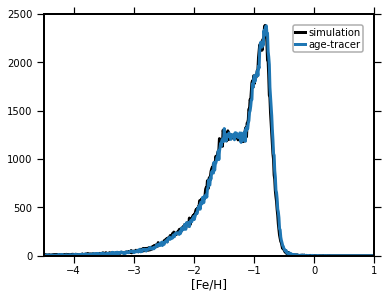

In [232]:
# plot the results
element_name = 'fe'

from utilities.basic.binning import BinClass

metallicity_limits = [-4.5, 1]
Bin = BinClass(metallicity_limits, width=0.01)

metallicity_sim = part[species_name].prop('metallicity.' + element_name)
metallicity_agetracer = part[species_name].prop('metallicity.agetracer.' + element_name).clip(-5, 10)

masks = (metallicity_agetracer > -5) * (metallicity_sim > -5)

distr_sim = Bin.get_distribution(metallicity_sim[masks])
distr_agetracer = Bin.get_distribution(metallicity_agetracer[masks])

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)

# plot the native abundances, computed directly in the simulation
ax.plot(distr_sim['bin'], distr_sim['sum'], lw=3, color='black', label='simulation')

# plot the post-processed abundances, from the age-tracer weights
ax.plot(distr_agetracer['bin'], distr_agetracer['sum'], lw=3, color='C0', label='age-tracer')

ax.legend(loc='best')
ax.set_ylim(0, None)
ax.set_xlim(metallicity_limits[0], metallicity_limits[1])
ax.set_xlabel('[Fe/H]')

#ut.statistic.print_statistics(metallicity_sim)

#ut.statistic.print_statistics(metallicity_agetracer)

difs = metallicity_agetracer - metallicity_sim

ut.statistic.print_statistics(difs)


# in utilities.basic.statistic.Statistic():
  number = 195238

  min = -1.271
  max = 1.329

  median = -0.021
  average = -0.019

  std = 0.029

  percent.0.1 = -0.233
  percent.2 = -0.050
  percent.16 = -0.027
  percent.50 = -0.021
  percent.84 = -0.014
  percent.98 = 0.024
  percent.99.9 = 0.215


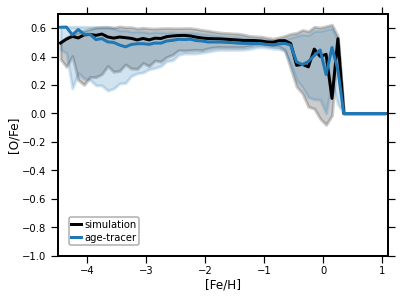

In [233]:
# plot the results

from utilities.basic.binning import BinClass

fe_limits = [-4.5, 1.1]
Bin = BinClass(fe_limits, width=0.1)

# plot the native abundances, computed directly in the simulation
fe_sim = part[species_name].prop('metallicity.fe')
alpha_sim = part[species_name].prop('metallicity.o - metallicity.fe')
fe_agetracer = part[species_name].prop('metallicity.agetracer.fe').clip(-5, 10)
alpha_agetracer = part[species_name].prop('metallicity.agetracer.o').clip(-5, 10) - fe_agetracer

masks = (fe_sim > -4.5) * (fe_agetracer > -4.5)

stats_sim = Bin.get_statistics_of_array(fe_sim[masks], alpha_sim[masks])
stats_agetracer = Bin.get_statistics_of_array(fe_agetracer[masks], alpha_agetracer[masks])

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)

ax.plot(stats_sim['bin.mid'], stats_sim['median'], lw=3, color='black', label='simulation')
ax.fill_between(
    stats_sim['bin.mid'], stats_sim['percent.16'], stats_sim['percent.84'], alpha=0.2, lw=3, color='black')

# plot the post-processed abundances, from the age-tracer weights


ax.plot(stats_agetracer['bin.mid'], stats_agetracer['median'], lw=3, color='C0', label='age-tracer')
ax.fill_between(
    stats_agetracer['bin.mid'], stats_agetracer['percent.16'], stats_agetracer['percent.84'], alpha=0.2, lw=3, color='C0')
#print(stats['median'])

ax.legend(loc='best')
ax.set_ylim(-1, 0.7)
ax.set_xlim(fe_limits[0], fe_limits[1])
ax.set_ylabel('[O/Fe]')
ax.set_xlabel('[Fe/H]')

difs = alpha_agetracer[masks] - alpha_sim[masks]

ut.statistic.print_statistics(difs)

## NuGrid

As another example, lets generate the NuGrid tables and re-do the above with those. This
requires having NuPYCee and Sygma installed (https://nugrid.github.io/NuPyCEE/index.html)

In [ ]:
# the NuGrid_yields class accepts kwargs to pass to the underlying
# sygma model, so this allows for the use of the full Symga / NuGrid framework.
#    this simple example just passes metallicity
NuGrid_yield_model = gizmo.agetracers.NuGrid_yields(iniZ = 0.01 # metal mass fraction (must equal a NuGrid table value)
                                                    )


NuGrid_yield_table = gizmo.agetracers.construct_yield_table(NuGrid_yield_model,
                                                            part.ageprop.age_bins/1000.0)

# again, elements to generate for yield table are arbitary as long as 
# they are included in the yield model. Below uses all available elements:
part.set_yield_table(NuGrid_yield_table, [str.lower(x) for x in NuGrid_yield_model.elements])

In [ ]:
# Lets try this out with the NuGrid data now!

from utilities.basic.binning import BinClass

fig,ax=plt.subplots()
fig.set_size_inches(6,4)

bc    = BinClass([-4,2],number= int((2-(-4))/0.1))

# plot the native simulation data:
stats = bc.get_statistics_of_array(  part['star'].prop('metallicity.fe'),
                                     part['star'].prop('metallicity.alpha - metallicity.fe'))
    
    
ax.plot(stats['bin.mid'][:-1], stats['median'][:-1], lw=3, color = 'black', label = 'Simulation')
ax.fill_between(stats['bin.mid'], stats['percent.16'], stats['percent.84'], alpha=0.2,
                lw = 3, color='black')


# plot the post-processed data.
# this can be done with just the ".agetracer" string, which works
# for all things that the elements work on already (metallicity, mass, massfraction, etc.)
bc    = BinClass([-4,2],number= int((2-(-4))/0.1))
stats = bc.get_statistics_of_array(part['star'].prop('metallicity.agetracer.fe'),
                                   part['star'].prop('metallicity.agetracer.alpha - metallicity.agetracer.fe'))
    
    
ax.plot(stats['bin.mid'][:-1], stats['median'][:-1], lw=3, color = 'C0', label = 'NuGrid - solar')
ax.fill_between(stats['bin.mid'], stats['percent.16'], stats['percent.84'], alpha=0.2,
                lw = 3, color='C0')


ax.legend(loc='best')
ax.set_ylim(-1,1)
ax.set_xlim(-4,2)
ax.set_ylabel(r'[$\alpha$/Fe]')
ax.set_xlabel('[Fe/H]')